# Drug classification

## 1. Preprocessing

In [43]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [44]:
df = pd.read_csv('drug200.csv')

In [45]:
df.head(5)

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,F,HIGH,HIGH,25.355,DrugY
1,47,M,LOW,HIGH,13.093,drugC
2,47,M,LOW,HIGH,10.114,drugC
3,28,F,NORMAL,HIGH,7.798,drugX
4,61,F,LOW,HIGH,18.043,DrugY


In [46]:
unique_drugnames = df.Drug.unique()

In [47]:
df.shape

(200, 6)

In [48]:
df.describe()

,Age,Na_to_K
count,200.000000,200.000000
mean,44.315000,16.084485
std,16.544315,7.223956
min,15.000000,6.269000
25%,31.000000,10.445500
50%,45.000000,13.936500
75%,58.000000,19.380000
max,74.000000,38.247000


In [49]:
df.isna().sum()

Age            0
Sex            0
BP             0
Cholesterol    0
Na_to_K        0
Drug           0
dtype: int64

In [50]:
df.dtypes

Age              int64
Sex             object
BP              object
Cholesterol     object
Na_to_K        float64
Drug            object
dtype: object

In [51]:
df['Sex'] = pd.Categorical(df['Sex'])
df['BP'] = pd.Categorical(df['BP'])
df['Cholesterol'] = pd.Categorical(df['Cholesterol'])
df['Drug'] = pd.Categorical(df['Drug'])

## 2.Visualization

In [52]:
df_for_viz = df.copy()
for column in df_for_viz.select_dtypes(include='category').columns:
    df_for_viz[column] = df_for_viz[column].cat.codes

### All-vs-All correlation

<AxesSubplot:>

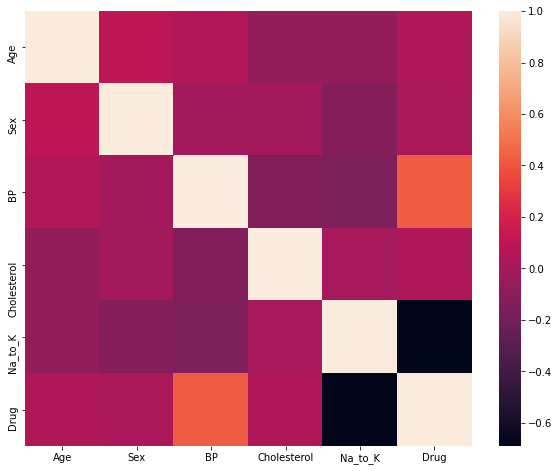

In [53]:
plt.figure(figsize=(10,8))
sns.heatmap(df_for_viz.corr())

### Distribution plots

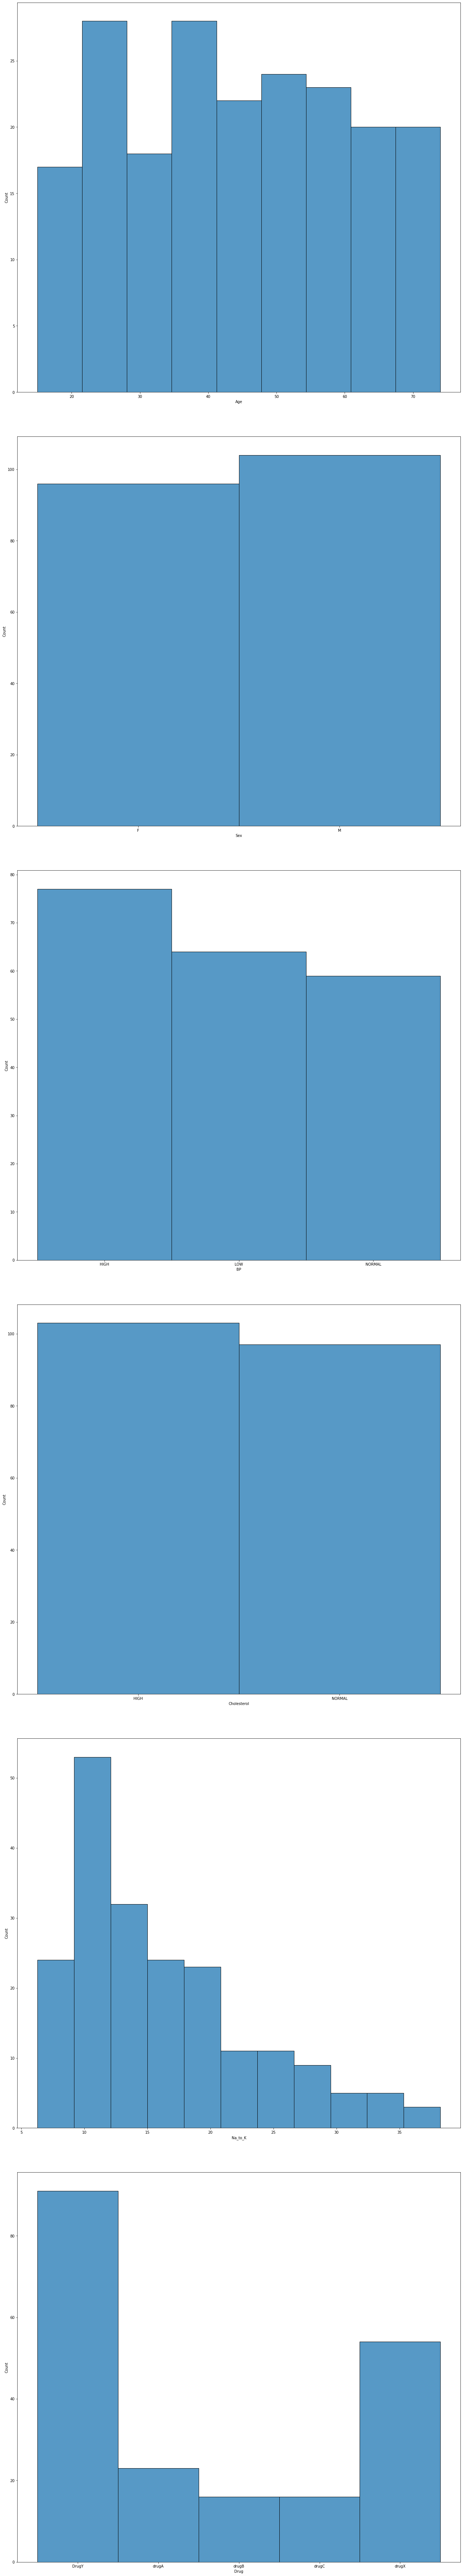

In [54]:
fig, axes = plt.subplots(nrows=df.shape[1], ncols=1,figsize=(20,100))
fig.tight_layout(pad=10.0)
ax_iter = iter(axes.flat)
for column in df.columns:
    ax = next(ax_iter)
    a = sns.histplot(df[column],ax=ax)

### Boxplots conditioned on label

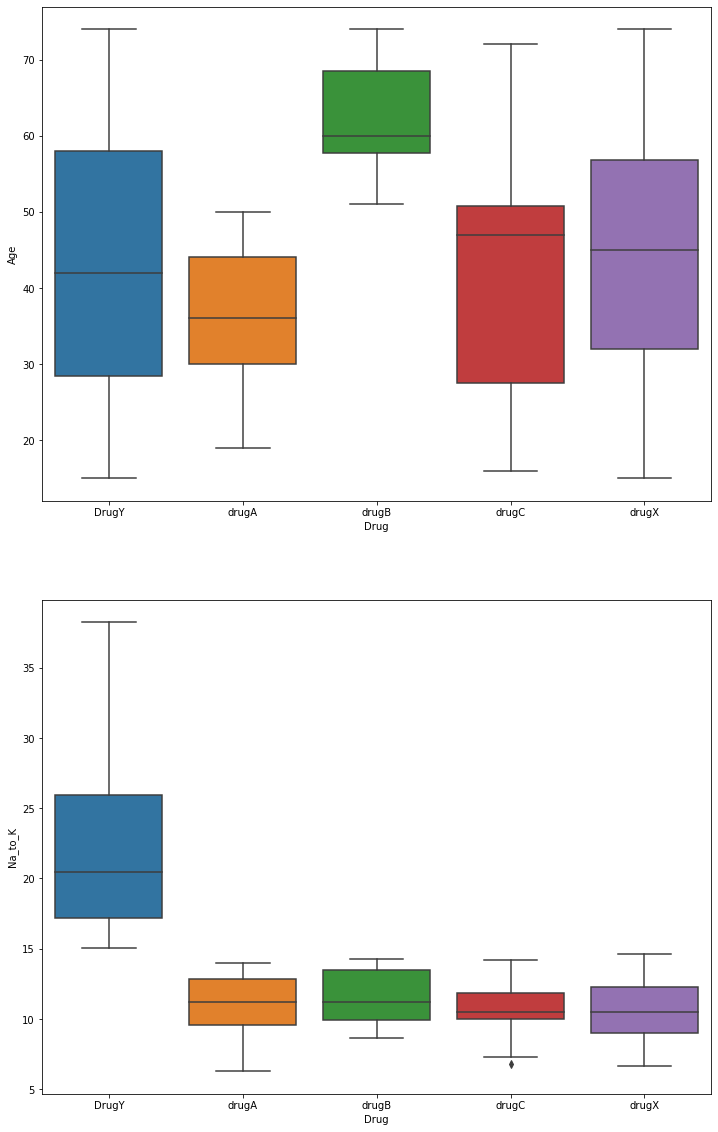

In [55]:
fig, axes = plt.subplots(nrows=2, ncols=1,figsize=(12,20))
ax_iter = iter(axes.flat)
for column in ['Age', 'Na_to_K']:
    ax = next(ax_iter)
    a = sns.boxplot(x='Drug', y=column, data=df,ax=ax)

## 3. ML Time

In [56]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, classification_report, confusion_matrix

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier

### One-Hot encoding

In [57]:
for column in df.select_dtypes(include='category').columns:
    if column=='Drug':
        continue
    df = pd.concat([df, pd.get_dummies(df[column], prefix=column)],axis=1)
    df.drop([column],axis=1, inplace=True)

In [58]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('Drug',axis=1), df['Drug'].cat.codes, test_size=0.2, random_state=42)

### Numerical features scaling

In [59]:
for column in df.select_dtypes(include='int64').columns:
    scale = StandardScaler().fit(X_train[[column]])
    X_train[[column]] = scale.transform(X_train[[column]])
    X_test[[column]] = scale.transform(X_test[[column]])

### KNN

In [60]:
n_neighbors = list(range(10,15))
hyperparameters = dict(n_neighbors=n_neighbors)
knn = KNeighborsClassifier()
clf = GridSearchCV(knn, hyperparameters, cv=3, n_jobs=-1, verbose=10)
best_model = clf.fit(X_train,y_train)
print('Best n_neighbors:', best_model.best_estimator_.get_params()['n_neighbors'])

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of  15 | elapsed:    1.5s remaining:    9.7s
[Parallel(n_jobs=-1)]: Done   4 out of  15 | elapsed:    1.5s remaining:    4.2s
[Parallel(n_jobs=-1)]: Done   6 out of  15 | elapsed:    1.5s remaining:    2.3s
[Parallel(n_jobs=-1)]: Done   8 out of  15 | elapsed:    1.5s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done  10 out of  15 | elapsed:    1.6s remaining:    0.8s


Best n_neighbors: 10


[Parallel(n_jobs=-1)]: Done  12 out of  15 | elapsed:    1.7s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    1.8s finished


In [61]:
knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(X_train,y_train)
y_pred = knn.predict(X_test)

In [62]:
knn.score(X_test, y_test)

0.875

In [63]:
f1_score(y_test, y_pred, average='macro')

0.8081987577639753

### Decision Tree

In [64]:
max_depth = [None,5,10,15]
hyperparameters = dict(max_depth=max_depth)
dtc = DecisionTreeClassifier()
clf = GridSearchCV(dtc, hyperparameters, cv=3, n_jobs=-1, verbose=10)
best_model = clf.fit(X_train,y_train)
max_depth = best_model.best_estimator_.get_params()['max_depth']
print('Best max_depth:', max_depth)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best max_depth: None


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0274s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   3 out of  12 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   5 out of  12 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   7 out of  12 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  12 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    0.1s finished


In [65]:
dtc = DecisionTreeClassifier(max_depth=max_depth)
dtc.fit(X_train,y_train)
y_pred = dtc.predict(X_test)
print('Score:', dtc.score(X_test, y_test))
print(f1_score(y_test, y_pred, average='macro'))

Score: 1.0
1.0


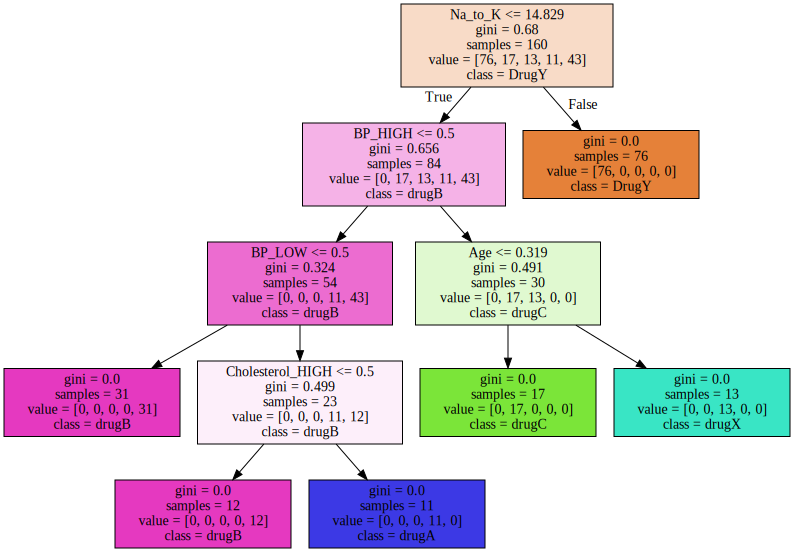

In [66]:
import graphviz
dot_data = export_graphviz(dtc, out_file=None, 
                                feature_names=X_train.columns,  
                                class_names=unique_drugnames,
                                filled=True)
graph = graphviz.Source(dot_data, format="png") 
graph

### SVM

In [67]:
c = [0.1, 1, 2]
gamma = [0.1, 0.5]
kernel = ['rbf']
hyperparameters = dict(C=c, gamma=gamma, kernel=kernel)
svc = SVC()
clf = GridSearchCV(svc, hyperparameters, cv=2, n_jobs=-1, verbose=10)
best_model = clf.fit(X_train,y_train)
print('Best C:', best_model.best_estimator_.get_params()['C'])
print('Best gamma:', best_model.best_estimator_.get_params()['gamma'])
print('Best kernel:', best_model.best_estimator_.get_params()['kernel'])

Fitting 2 folds for each of 6 candidates, totalling 12 fits
Best C: 2
Best gamma: 0.1
Best kernel: rbf


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0206s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   3 out of  12 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   5 out of  12 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   7 out of  12 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  12 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    0.1s finished


In [68]:
svc = SVC(C=2, kernel='rbf', gamma=0.1)
svc.fit(X_train,y_train)
y_pred = svc.predict(X_test)

In [69]:
svc.score(X_test, y_test)

1.0

In [70]:
f1_score(y_test, y_pred, average='macro')

1.0

### Random Forest

In [71]:
n_estimators = [5, 10, 100, 200, 500]
max_depth = [None, 5, 10,15,20,25]
min_samples_split = [0.1,0.25,0.5,1,2]
hyperparameters = dict(n_estimators=n_estimators, max_depth=max_depth, min_samples_split=min_samples_split)
rfc = RandomForestClassifier()
clf = GridSearchCV(rfc, hyperparameters, cv=2, n_jobs=-1, verbose=10)
best_model = clf.fit(X_train,y_train)
print('Best n_estimators:', best_model.best_estimator_.get_params()['n_estimators'])
print('Best max_depth:', best_model.best_estimator_.get_params()['max_depth'])
print('Best min_samples_split:', best_model.best_estimator_.get_params()['min_samples_split'])

Fitting 2 folds for each of 150 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0385s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Batch computation too slow (2.1698s.) Setting batch_size=1.
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done 135 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    8.9s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 185 tasks      | elapsed:   11.0s
[Parallel(n_jo

Best n_estimators: 500
Best max_depth: None
Best min_samples_split: 0.1


In [72]:
rfc = RandomForestClassifier(n_estimators=10, max_depth=None, min_samples_split=0.1)
rfc.fit(X_train,y_train)
y_pred = rfc.predict(X_test)
rfc.score(X_test, y_test)

1.0

In [73]:
f1_score(y_test, y_pred, average='macro')

1.0

### AdaBoost

In [74]:
n_estimators = [10, 50, 100, 500]
learning_rate = [0.1, 0.5, 1, 2, 5, 10]
algorithm = ['SAMME', 'SAMME.R']
hyperparameters = dict(n_estimators=n_estimators, learning_rate=learning_rate, algorithm=algorithm)
abc = AdaBoostClassifier()
clf = GridSearchCV(abc, hyperparameters, cv=2, n_jobs=-1, verbose=10)
best_model = clf.fit(X_train,y_train)
print('Best n_estimators:', best_model.best_estimator_.get_params()['n_estimators'])
print('Best learning_rate:', best_model.best_estimator_.get_params()['learning_rate'])
print('Best algorithm:', best_model.best_estimator_.get_params()['algorithm'])

Fitting 2 folds for each of 48 candidates, totalling 96 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0425s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  20 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    2.2s


Best n_estimators: 100
Best learning_rate: 2
Best algorithm: SAMME


[Parallel(n_jobs=-1)]: Done  96 out of  96 | elapsed:    6.5s finished


In [75]:
abc = AdaBoostClassifier(n_estimators=100, learning_rate=2, algorithm='SAMME')
abc.fit(X_train,y_train)
y_pred = abc.predict(X_test)
abc.score(X_test, y_test)

1.0

In [76]:
f1_score(y_test, y_pred, average='macro')

1.0

### Gradient Boost

In [77]:
learning_rate = [0.01, 0.1, 0.5]
n_estimators = [100, 250, 500]
max_depth = [3, 5, 7]
hyperparameters = dict(learning_rate=learning_rate, n_estimators=n_estimators, max_depth=max_depth)
gbc = GradientBoostingClassifier()
clf = GridSearchCV(gbc, hyperparameters, cv=2, n_jobs=-1, verbose=10)
best_model = clf.fit(X_train,y_train)
print('Best learning_rate:', best_model.best_estimator_.get_params()['learning_rate'])
print('Best n_estimators:', best_model.best_estimator_.get_params()['n_estimators'])
print('Best max_depth:', best_model.best_estimator_.get_params()['max_depth'])

Fitting 2 folds for each of 27 candidates, totalling 54 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   12.3s
[Parallel(n_jobs=-1)]: Done  45 out of  54 | elapsed:   15.9s remaining:    3.2s
[Parallel(n_jobs=-1)]: Done  51 out of  54 | elapsed:   18.1s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:   19.3s finished


Best learning_rate: 0.5
Best n_estimators: 100
Best max_depth: 7


In [78]:
gbc = GradientBoostingClassifier(n_estimators=500, learning_rate=0.5, max_depth=5)
gbc.fit(X_train,y_train)
y_pred = gbc.predict(X_test)
gbc.score(X_test, y_test)

1.0

In [79]:
f1_score(y_test, y_pred, average='macro')

1.0

# Best model by f1-score - DecisionTreeClassifier

In [80]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         3
           3       1.00      1.00      1.00         5
           4       1.00      1.00      1.00        11

    accuracy                           1.00        40
   macro avg       1.00      1.00      1.00        40
weighted avg       1.00      1.00      1.00        40



In [81]:
print(confusion_matrix(y_test, y_pred))

[[15  0  0  0  0]
 [ 0  6  0  0  0]
 [ 0  0  3  0  0]
 [ 0  0  0  5  0]
 [ 0  0  0  0 11]]
